In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_probability as tfp

In [2]:
# define problem parameters
n = 270
N = 1024
k = 40

# define number of training/validation/testing samples
num_train_samples = 75000
num_valid_samples = 25000
num_test_samples = 25000
total_num_samples = num_train_samples + num_valid_samples + num_test_samples

# use default rng
rng = np.random.default_rng()

# sensing matrix
A = np.sqrt(1/n)*np.random.randn(n, N)

In [12]:
# define ouf threshold ad onsager functions
def eta(u, T):
    return (u - T)*(u >= T) + (u + T)*(u <= -T)

# calc as L0 norm
def onsager(z, r, tau, n):
    return (z/n) * np.sum(eta(r, tau) != 0)

# MSE vs. n

In [11]:
# initalize some parameters
sigma = .05
s = 0.2
lambda_ = 0.1

# arrays for plotting
mse_ist_v_n = np.zeros(6)
mse_amp_v_n = np.zeros(6)
n_vec = np.arange(200, 320, 20)
avg_over = 200
num_iterations = 5

# initial A, x, y
A = np.sqrt(1/n)*np.random.randn(n, N)

x = np.zeros((N, 1))
idx_nonzero_entries = np.random.permutation(N)[0:k]
x[idx_nonzero_entries] = 1

y = A @ x 

IST running for various n values -- noiseless

In [12]:
cnt = 0
mse = 0

# go through val 200-300
for loc_n in range(200, 320, 20):
    for run in range(avg_over):  # takes an average after may runs through
      # reset for next n value
        z = np.zeros(y.shape)
        xHt = np.zeros(x.shape)
        A = np.sqrt(1/loc_n)*np.random.randn(loc_n, N)
        y = A @ x    
        for idx_iter in range(num_iterations):  # follow IST
            z = y - A @ xHt  # residual error
            r = xHt + s * A.T @ z  # term to be thresholded
            xHt = eta(r, s*lambda_)  # update estimate of x
        mse += (1/N) * np.sum((x - xHt)**2)  # mse
    mse_ist_v_n[cnt] = (1/avg_over) * mse  # avg of the mse vals
    n_vec[cnt] = loc_n
    cnt += 1
    mse = 0

AMP running for various n values -- noiseless

In [13]:
#AMP vs. n
mse = 0
cnt = 0

# loop through n values of 200-300
for loc_n in range(200, 320, 20):
    for avg in range(avg_over):  # take the avearage after lots of iterations for better results
        # compute first A and y
        A = np.sqrt(1/loc_n)*np.random.randn(loc_n, N)
        y = A @ x 
        # rst z, r, tau, xHt for next iteration
        z = np.zeros(y.shape)
        r = np.zeros(x.shape)
        tau = 0
        xHt = np.zeros(x.shape)
        for idx_iter in range(num_iterations):
            ons = onsager(z, r, tau, loc_n) #calulate next onsager
            z = y - A @ xHt + ons  # residual error
            tau = np.sqrt((1/loc_n)) * np.linalg.norm(z) # update tau
            r = xHt + A.T @ z
            xHt = eta(r, tau)  # threshold
        # holds running total of mse
        mse += (1/N) * sum((x-xHt)**2)
    mse_amp_v_n[cnt] = (1/avg_over) * mse
    mse = 0 # reset for next n
    cnt += 1

Plot the results

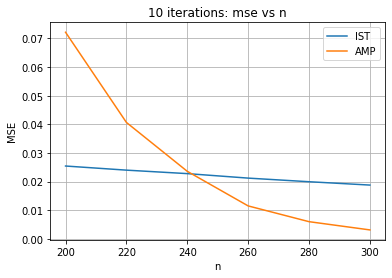

 N = 1024 | k = 40


In [14]:
# Plot results
plt.figure()
plt.plot(n_vec, mse_ist_v_n, label="IST")
plt.plot(n_vec, mse_amp_v_n, label="AMP")
plt.legend()
plt.xlabel('n')
plt.ylabel('MSE')
plt.grid(True, which='both')
plt.title(f'{num_iterations} iterations: mse vs n')
plt.show()
print(f' N = {N} | k = {k}')

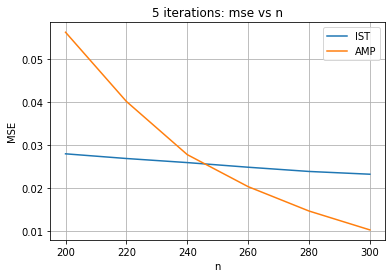

 N = 1024 | k = 40


In [ ]:
# Plot results
plt.figure()
plt.plot(n_vec, mse_ist_v_n, label="IST")
plt.plot(n_vec, mse_amp_v_n, label="AMP")
plt.legend()
plt.xlabel('n')
plt.ylabel('MSE')
plt.grid(True, which='both')
plt.title(f'{num_iterations} iterations: mse vs n')
plt.show()
print(f' N = {N} | k = {k}')

The above graphs gave me intuition on how the number of measurements affects AMP's performance. This lead me to choose n = 270 as the parameter to use when evaluating LISTA.

# Unlearned vs iterations

In [15]:
# define some parameters
num_iterations = 5
mse_amp = np.zeros(num_iterations)
mse_ist = np.zeros(num_iterations)

In [16]:
# Prep for AMP
z = np.zeros(y.shape)
xHt = np.zeros(x.shape)
r = 0
tau = 0
ons = 0

#AMP
for idx_iter in range(num_iterations):
    ons = onsager(z, r, tau, n) #calulate next onsager
    z = y - A @ xHt + ons
    tau = np.sqrt(1/n) * np.linalg.norm(z)
    r = xHt + A.T @ z
    xHt = eta(r, tau)

    # find the current error
    mse_amp[idx_iter] = (1/N) * np.sum((x - xHt)**2)

In [17]:
# IST
xHt = np.zeros(x.shape)
r = 0
z = np.zeros(y.shape)

# iterate through IST
for idx_iter in range(num_iterations):
    z = y - A @ xHt  # residual error
    r = xHt + s * A.T @ z
    xHt = eta(r, s*lambda_)  
    # find the current error
    mse_ist[idx_iter] = (1/N) * np.sum((x - xHt)**2)

# LISTA

In [18]:
# creating training set
# create sensing matrix A
A = np.sqrt(1/n)*np.random.randn(n, N)

# create data
x = np.zeros((total_num_samples, N))
idx_nonzero = rng.permuted(np.tile(np.arange(N), (total_num_samples, 1)), axis=1)
for i in range(k):
  x[np.arange(total_num_samples), idx_nonzero[:, i].flatten()] = 1
y = x @ A.T
y = np.hstack((np.zeros((total_num_samples, N)), y))

# Divide data into training, validation, testing sets
train_data = y[0:num_train_samples, :]
train_labels = x[0:num_train_samples, :]
valid_data = y[num_train_samples:num_train_samples+num_valid_samples, :]
valid_labels = x[num_train_samples:num_train_samples+num_valid_samples, :]
test_data = y[num_train_samples+num_valid_samples:, :]
test_labels = x[num_train_samples+num_valid_samples:, :]

In [4]:
# creating initial values for trainable parameters

_, Lambda, _ = np.linalg.svd(A)
L = np.max(Lambda) + 1
init_alpha = 0.1

# creating the Identity matrix
I = np.zeros((N,N))
for i in range(N):
  for j in range(N):
    if i == j:
      I[i][j] = 1

init_Q = I - (A.T @ A) / L
init_W = A / L

In [5]:
class SimpleLISTALayer(keras.layers.Layer):
  
  # defining variables for the layer
  def __init__(self, A, L, init_alpha, Q, W):
    super().__init__()
    self.A = A #tf.Variable(initial_value=A, dtype='float32', trainable=True)
    self.L = L
    self.n, self.N = self.A.shape  # dimensions for x, y
    self.alpha = tf.Variable(initial_value=init_alpha, dtype='float32', trainable=True)  # sparisty factor
    self.Q = tf.Variable(initial_value=init_Q, dtype='float32', trainable=True) # weight for x
    self.W = tf.Variable(initial_value=init_W, dtype='float32', trainable=True)  # weight for y

  # creating inputs and updating things on each call
  def call(self, inputs):  # this is what happens at each layer call
  # unstacks xHt|y (they come in as one thing so we only have to deal with one input)
    xHt = inputs[:, 0:self.N] 
    y = inputs[:, self.N:]
    #update = xHt - (1/self.L)*tf.matmul((tf.matmul(xHt, tf.transpose(self.A)) - y), self.A)  # training A, alpha only
    update = xHt @ self.Q + y @ self.W
    new_x = tfp.math.soft_threshold(update, self.alpha/self.L)  
    return tf.concat([new_x, y], axis=1)  # output a single vector xHt|y stacked

class CustomMSELoss(keras.losses.Loss):
# defining our loss function
  def __init__(self, N):
    super().__init__()
    self.N = N
  
  def call(self, true, pred):
    x_true = true[:, 0:self.N]
    x_pred = pred[:, 0:self.N]
    # squared diff: returns tensor of the squared diff
    # reduce mean: takes teh average of the tensor
    return tf.reduce_mean(tf.math.squared_difference(x_true, x_pred))
  
class CustomMSEMetric(keras.metrics.Mean):
# defining our metric
  def __init__(self, N):
    super().__init__()
    self.N = N

  def update_state(self, true, pred, sample_weight=None):
    x_true = true[:, 0:self.N]
    x_pred = pred[:, 0:self.N]
    val = tf.reduce_mean(tf.math.squared_difference(x_true, x_pred))
    # stores it in the "result" call
    return super().update_state(val, sample_weight=None)

In [21]:
cnt = 1
results_to_plot = []
num_layers = 5

for j in tqdm(range(num_layers)):
  # create initial input
  input = keras.layers.Input(shape=(n+N,), name='y_inputs')
  for idx_layer in range(cnt):  # cnt updates each time so this is a variable number of iterations
    # calls the layer differently depending on what layer it is 
    if cnt == 1:  # onelayer means you directly compute the output. xHt = 0
      output = SimpleLISTALayer(A, L, init_alpha, init_Q, init_W) (input)
    elif cnt > 1:
      if idx_layer == 0:  # create "hidden" layer with xHt = 0
        x_hidden = SimpleLISTALayer(A, L, init_alpha, init_Q, init_W) (input)
      elif idx_layer == cnt - 1:  # output is populated on the last layer
        output = SimpleLISTALayer(A, L, init_alpha, init_Q, init_W) (x_hidden)
      else:  # all other layers update hidden layer with result from previous hidden layer
        x_hidden = SimpleLISTALayer(A, L, init_alpha, init_Q, init_W) (x_hidden)

  # increase count so it goes through more iterations next time
  cnt += 1

  model = keras.Model(inputs=input, outputs=output, name='SimplifiedLISTAModel')
  # compile keras model
  custom_mse_loss = CustomMSELoss(N)
  custom_mse_metric = CustomMSEMetric(N)
  model.compile(optimizer='Adam', loss=custom_mse_loss, metrics=[custom_mse_metric])
  print(model.summary())  # visualizes the model

  # train model
  history = model.fit(train_data,
                    train_labels,
                    batch_size=128, 
                    epochs=3,
                    validation_data=(valid_data, valid_labels))
  
  # evaluate the performance
  results = model.evaluate(test_data, test_labels)
  results_to_plot.append(results[0])
  print(f'Final MSE on test data: {results[0]}')

  0%|          | 0/5 [00:00<?, ?it/s]

Model: "SimplifiedLISTAModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 y_inputs (InputLayer)       [(None, 1294)]            0         
                                                                 
 simple_lista_layer (SimpleL  (None, 1294)             1325057   
 ISTALayer)                                                      
                                                                 
Total params: 1,325,057
Trainable params: 1,325,057
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/3
586/586 [==============================] - 5s 5ms/step - loss: 0.0236 - mean: 0.0236 - val_loss: 0.0210 - val_mean: 0.0210
Epoch 2/3
586/586 [==============================] - 2s 4ms/step - loss: 0.0196 - mean: 0.0196 - val_loss: 0.0186 - val_mean: 0.0186
Epoch 3/3
782/782 [==============================] - 2s 3ms/step - loss: 0.0172 - mean: 0.0172


 20%|██        | 1/5 [00:17<01:08, 17.06s/it]

Final MSE on test data: 0.01723681576550007
Model: "SimplifiedLISTAModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 y_inputs (InputLayer)       [(None, 1294)]            0         
                                                                 
 simple_lista_layer_1 (Simpl  (None, 1294)             1325057   
 eLISTALayer)                                                    
                                                                 
 simple_lista_layer_2 (Simpl  (None, 1294)             1325057   
 eLISTALayer)                                                    
                                                                 
Total params: 2,650,114
Trainable params: 2,650,114
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/3
586/586 [==============================] - 3s 5ms/step - loss: 0.0209 - mean: 0.0209 - val_loss: 0.0172 - val

 40%|████      | 2/5 [00:29<00:43, 14.62s/it]

Final MSE on test data: 0.010286420583724976
Model: "SimplifiedLISTAModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 y_inputs (InputLayer)       [(None, 1294)]            0         
                                                                 
 simple_lista_layer_3 (Simpl  (None, 1294)             1325057   
 eLISTALayer)                                                    
                                                                 
 simple_lista_layer_4 (Simpl  (None, 1294)             1325057   
 eLISTALayer)                                                    
                                                                 
 simple_lista_layer_5 (Simpl  (None, 1294)             1325057   
 eLISTALayer)                                                    
                                                                 
Total params: 3,975,171
Trainable params: 3,975,171
Non-trainable p

 60%|██████    | 3/5 [00:43<00:28, 14.29s/it]

Final MSE on test data: 0.007578729186207056
Model: "SimplifiedLISTAModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 y_inputs (InputLayer)       [(None, 1294)]            0         
                                                                 
 simple_lista_layer_6 (Simpl  (None, 1294)             1325057   
 eLISTALayer)                                                    
                                                                 
 simple_lista_layer_7 (Simpl  (None, 1294)             1325057   
 eLISTALayer)                                                    
                                                                 
 simple_lista_layer_8 (Simpl  (None, 1294)             1325057   
 eLISTALayer)                                                    
                                                                 
 simple_lista_layer_9 (Simpl  (None, 1294)             1325057   
 

 80%|████████  | 4/5 [01:08<00:18, 18.40s/it]

Final MSE on test data: 0.006410527974367142
Model: "SimplifiedLISTAModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 y_inputs (InputLayer)       [(None, 1294)]            0         
                                                                 
 simple_lista_layer_10 (Simp  (None, 1294)             1325057   
 leLISTALayer)                                                   
                                                                 
 simple_lista_layer_11 (Simp  (None, 1294)             1325057   
 leLISTALayer)                                                   
                                                                 
 simple_lista_layer_12 (Simp  (None, 1294)             1325057   
 leLISTALayer)                                                   
                                                                 
 simple_lista_layer_13 (Simp  (None, 1294)             1325057   
 

100%|██████████| 5/5 [01:34<00:00, 18.89s/it]

Final MSE on test data: 0.005695881322026253


Plot the results

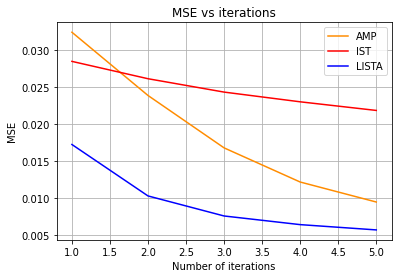

n = 270 | N = 1024 | k = 40


In [22]:
plt.figure()
plt.plot(range(1,num_iterations+1), mse_amp, label="AMP", color="darkorange")
plt.plot(range(1,num_iterations+1), mse_ist, label="IST", color="red")
plt.plot(range(1,num_iterations+1), results_to_plot, label="LISTA", color="blue")
plt.title("MSE vs iterations")
plt.xlabel("Number of iterations")
plt.ylabel("MSE")
plt.legend()
plt.grid(True, which='both')
plt.show()
print(f'n = {n} | N = {N} | k = {k}')

# Unlearned noisy graphs

In [ ]:
# noise vec
# corresponds to SNRs of  10, 20, 30 dB
sigma = [0.31622776601683794, 0.1, 0.03162277660168379]
A = np.sqrt(1/n)*np.random.randn(n, N)

num_iterations = 5

# noisy mse arrays
noise_mse_ist = np.zeros(num_iterations)
noise_mse_amp = np.zeros(num_iterations)

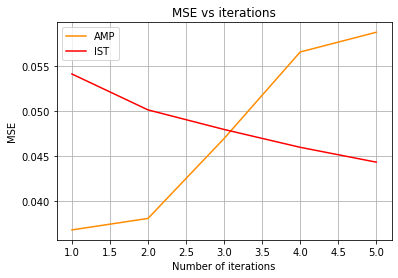

n = 270 | N = 1024 | k = 40 | SNR = 10dB



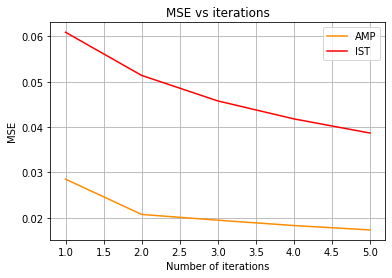

n = 270 | N = 1024 | k = 40 | SNR = 20dB



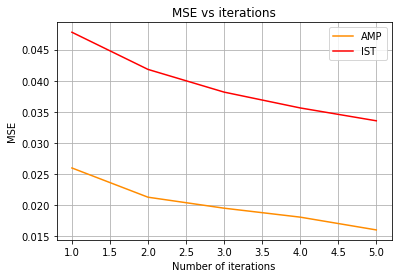

n = 270 | N = 1024 | k = 40 | SNR = 30dB



In [ ]:
for i in range(len(sigma)):  # loop through all the sigma values
# create initial x, y
  w = sigma[i]*np.random.randn(n).reshape(-1,1)
  x = np.zeros((N, 1))
  idx_nonzero_entries = np.random.permutation(N)[0:k]
  x[idx_nonzero_entries] = 1
  y = A @ x + w

  # do IST
  for idx_iter in range(num_iterations):
    z = y - A @ xHt
    r = xHt + s * A.T @ z
    xHt = eta(r, s*lambda_)
    # find the current error
    noise_mse_ist[idx_iter] = (1/N) * np.sum((x - xHt)**2)

  # do AMP
  for idx_iter in range(num_iterations):
    ons = onsager(z, r, tau, n) #calulate next onsager
    z = y - A @ xHt + ons
    tau = np.sqrt(1/n) * np.linalg.norm(z)
    r = xHt + A.T @ z
    xHt = eta(r, tau)

    # find the current error
    noise_mse_amp[idx_iter] = (1/N) * np.sum((x - xHt)**2)

  # plot the results
  plt.figure()
  plt.plot(range(1,num_iterations+1), noise_mse_amp, label="AMP", color="darkorange")
  plt.plot(range(1,num_iterations+1), noise_mse_ist, label="IST", color="red")
  plt.title("MSE vs iterations")
  plt.xlabel("Number of iterations")
  plt.ylabel("MSE")
  plt.legend()
  plt.grid(True, which='both')
  plt.show()

  if i ==0:
    snr = 10
  elif i == 1:
    snr = 20
  elif i == 2:
    snr = 30
  print(f'n = {n} | N = {N} | k = {k} | SNR = {snr}dB\n')

AMP does not perform well at less than a 10dB SNR, but it outperforms IST when the SNR is greater than 10dB

# Noisy LISTA

This uses the same layer class, but it creates a training set that has noise

First, we do the 10dB SNR case

In [23]:
# create sensing matrix A
A = np.sqrt(1/n)*np.random.randn(n, N)

# corresponds to SNRs of 10, 20, 30
sigma = [0.31622776601683794, 0.1, 0.03162277660168379]

z = []
# noise vector
for i in range(total_num_samples):
  z.append(sigma[0]*np.random.randn(n))
z = np.array(z)
print(z.shape)


# create data
x = np.zeros((total_num_samples, N))
idx_nonzero = rng.permuted(np.tile(np.arange(N), (total_num_samples, 1)), axis=1)
for i in range(k):
  x[np.arange(total_num_samples), idx_nonzero[:, i].flatten()] = 1
y = x @ A.T + z  # adding noise here
y = np.hstack((np.zeros((total_num_samples, N)), y))

# Divide data into training, validation, testing sets
train_data = y[0:num_train_samples, :]
train_labels = x[0:num_train_samples, :]
valid_data = y[num_train_samples:num_train_samples+num_valid_samples, :]
valid_labels = x[num_train_samples:num_train_samples+num_valid_samples, :]
test_data = y[num_train_samples+num_valid_samples:, :]
test_labels = x[num_train_samples+num_valid_samples:, :]

(125000, 270)


In [25]:
cnt = 1
results_to_plot_10 = []
epoch_nums = [3,3,4,5,5]  # changes how many epochs we train each amt of layers for
num_layers = 5
for epoch in tqdm(epoch_nums):
  # create initial input
  input = keras.layers.Input(shape=(n+N,), name='y_inputs')
  for idx_layer in range(cnt):
    # calls the layer differently depending on what layer it is 
    if cnt == 1:
      output = SimpleLISTALayer(A, L, init_alpha, init_Q, init_W) (input)
    elif cnt > 1:
      if idx_layer == 0:
        x_hidden = SimpleLISTALayer(A, L, init_alpha, init_Q, init_W) (input)
      elif idx_layer == cnt - 1:  # output is populated on the last layer
        output = SimpleLISTALayer(A, L, init_alpha, init_Q, init_W) (x_hidden)
      else:
        x_hidden = SimpleLISTALayer(A, L, init_alpha, init_Q, init_W) (x_hidden)
    
 # increase count so it goes through more iterations next time
  cnt += 1

  model = keras.Model(inputs=input, outputs=output, name='SimplifiedLISTAModel')
  # compile keras model
  custom_mse_loss = CustomMSELoss(N)
  custom_mse_metric = CustomMSEMetric(N)
  model.compile(optimizer='Adam', loss=custom_mse_loss, metrics=[custom_mse_metric])
  print(model.summary())

  # train model
  history = model.fit(train_data,
                    train_labels,
                    batch_size=128,
                    epochs=epoch,
                    validation_data=(valid_data, valid_labels))

  results = model.evaluate(test_data, test_labels)
  results_to_plot_10.append(results[0])
  print(f'Final MSE on test data: {results[0]}')

  0%|          | 0/5 [00:00<?, ?it/s]

Model: "SimplifiedLISTAModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 y_inputs (InputLayer)       [(None, 1294)]            0         
                                                                 
 simple_lista_layer_16 (Simp  (None, 1294)             1325057   
 leLISTALayer)                                                   
                                                                 
Total params: 1,325,057
Trainable params: 1,325,057
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/3
586/586 [==============================] - 3s 4ms/step - loss: 0.0317 - mean: 0.0317 - val_loss: 0.0298 - val_mean: 0.0298
Epoch 2/3
586/586 [==============================] - 2s 4ms/step - loss: 0.0291 - mean: 0.0291 - val_loss: 0.0287 - val_mean: 0.0287
Epoch 3/3
782/782 [==============================] - 2s 2ms/step - loss: 0.0280 - mean: 0.0280


 20%|██        | 1/5 [00:15<01:03, 15.98s/it]

Final MSE on test data: 0.028008338063955307
Model: "SimplifiedLISTAModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 y_inputs (InputLayer)       [(None, 1294)]            0         
                                                                 
 simple_lista_layer_17 (Simp  (None, 1294)             1325057   
 leLISTALayer)                                                   
                                                                 
 simple_lista_layer_18 (Simp  (None, 1294)             1325057   
 leLISTALayer)                                                   
                                                                 
Total params: 2,650,114
Trainable params: 2,650,114
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/3
586/586 [==============================] - 4s 5ms/step - loss: 0.0320 - mean: 0.0320 - val_loss: 0.0300 - va

 40%|████      | 2/5 [00:27<00:39, 13.31s/it]

Final MSE on test data: 0.02716156095266342
Model: "SimplifiedLISTAModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 y_inputs (InputLayer)       [(None, 1294)]            0         
                                                                 
 simple_lista_layer_19 (Simp  (None, 1294)             1325057   
 leLISTALayer)                                                   
                                                                 
 simple_lista_layer_20 (Simp  (None, 1294)             1325057   
 leLISTALayer)                                                   
                                                                 
 simple_lista_layer_21 (Simp  (None, 1294)             1325057   
 leLISTALayer)                                                   
                                                                 
Total params: 3,975,171
Trainable params: 3,975,171
Non-trainable pa

 60%|██████    | 3/5 [00:52<00:37, 18.58s/it]

Final MSE on test data: 0.026832446455955505
Model: "SimplifiedLISTAModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 y_inputs (InputLayer)       [(None, 1294)]            0         
                                                                 
 simple_lista_layer_22 (Simp  (None, 1294)             1325057   
 leLISTALayer)                                                   
                                                                 
 simple_lista_layer_23 (Simp  (None, 1294)             1325057   
 leLISTALayer)                                                   
                                                                 
 simple_lista_layer_24 (Simp  (None, 1294)             1325057   
 leLISTALayer)                                                   
                                                                 
 simple_lista_layer_25 (Simp  (None, 1294)             1325057   
 

 80%|████████  | 4/5 [01:13<00:19, 19.70s/it]

Final MSE on test data: 0.026802878826856613
Model: "SimplifiedLISTAModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 y_inputs (InputLayer)       [(None, 1294)]            0         
                                                                 
 simple_lista_layer_26 (Simp  (None, 1294)             1325057   
 leLISTALayer)                                                   
                                                                 
 simple_lista_layer_27 (Simp  (None, 1294)             1325057   
 leLISTALayer)                                                   
                                                                 
 simple_lista_layer_28 (Simp  (None, 1294)             1325057   
 leLISTALayer)                                                   
                                                                 
 simple_lista_layer_29 (Simp  (None, 1294)             1325057   
 

100%|██████████| 5/5 [01:39<00:00, 19.82s/it]

Final MSE on test data: 0.026762567460536957


Next, the 20dB SNR case

In [6]:
# create sensing matrix A
A = np.sqrt(1/n)*np.random.randn(n, N)

# corresponds to SNRs of 10, 20, 30
sigma = [0.31622776601683794, 0.1, 0.03162277660168379]

z = []
# noise vector
for i in range(total_num_samples):
  z.append(sigma[1]*np.random.randn(n))
z = np.array(z)
print(z.shape)


# create data
x = np.zeros((total_num_samples, N))
idx_nonzero = rng.permuted(np.tile(np.arange(N), (total_num_samples, 1)), axis=1)
for i in range(k):
  x[np.arange(total_num_samples), idx_nonzero[:, i].flatten()] = 1
y = x @ A.T + z  # adding noise here
y = np.hstack((np.zeros((total_num_samples, N)), y))

# Divide data into training, validation, testing sets
train_data = y[0:num_train_samples, :]
train_labels = x[0:num_train_samples, :]
valid_data = y[num_train_samples:num_train_samples+num_valid_samples, :]
valid_labels = x[num_train_samples:num_train_samples+num_valid_samples, :]
test_data = y[num_train_samples+num_valid_samples:, :]
test_labels = x[num_train_samples+num_valid_samples:, :]

(125000, 270)


In [7]:
cnt = 1
results_to_plot_20 = []
epoch_nums = [4,5,5,5,5]  # changes how many epochs we train each amt of layers for
num_layers = 5
for epoch in epoch_nums:
  # create initial input
  input = keras.layers.Input(shape=(n+N,), name='y_inputs')
  for idx_layer in range(cnt):
    # calls the layer differently depending on what layer it is 
    if cnt == 1:
      output = SimpleLISTALayer(A, L, init_alpha, init_Q, init_W) (input)
    elif cnt > 1:
      if idx_layer == 0:
        x_hidden = SimpleLISTALayer(A, L, init_alpha, init_Q, init_W) (input)
      elif idx_layer == cnt - 1:  # output is populated on the last layer
        output = SimpleLISTALayer(A, L, init_alpha, init_Q, init_W) (x_hidden)
      else:
        x_hidden = SimpleLISTALayer(A, L, init_alpha, init_Q, init_W) (x_hidden)
    
 # increase count so it goes through more iterations next time
  cnt += 1

  model = keras.Model(inputs=input, outputs=output, name='SimplifiedLISTAModel')
  # compile keras model
  custom_mse_loss = CustomMSELoss(N)
  custom_mse_metric = CustomMSEMetric(N)
  model.compile(optimizer='Adam', loss=custom_mse_loss, metrics=[custom_mse_metric])
  print(model.summary())

  # train model
  history = model.fit(train_data,
                    train_labels,
                    batch_size=128,
                    epochs=epoch,
                    validation_data=(valid_data, valid_labels))

  results = model.evaluate(test_data, test_labels)
  results_to_plot_20.append(results[0])
  print(f'Final MSE on test data: {results[0]}')

Model: "SimplifiedLISTAModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 y_inputs (InputLayer)       [(None, 1294)]            0         
                                                                 
 simple_lista_layer (SimpleL  (None, 1294)             1325057   
 ISTALayer)                                                      
                                                                 
Total params: 1,325,057
Trainable params: 1,325,057
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/4
586/586 [==============================] - 5s 5ms/step - loss: 0.0261 - mean: 0.0261 - val_loss: 0.0226 - val_mean: 0.0226
Epoch 2/4
586/586 [==============================] - 2s 4ms/step - loss: 0.0213 - mean: 0.0213 - val_loss: 0.0203 - val_mean: 0.0203
Epoch 3/4
586/586 [==============================] - 2s 4ms/step - loss: 0.0195 - mean: 0.0195 

Finally, the 30dB SNR case

In [6]:
# create sensing matrix A
A = np.sqrt(1/n)*np.random.randn(n, N)

# corresponds to SNRs of 10, 20, 30
sigma = [0.31622776601683794, 0.1, 0.03162277660168379]

z = []
# noise vector
for i in range(total_num_samples):
  z.append(sigma[2]*np.random.randn(n))
z = np.array(z)
print(z.shape)


# create data
x = np.zeros((total_num_samples, N))
idx_nonzero = rng.permuted(np.tile(np.arange(N), (total_num_samples, 1)), axis=1)
for i in range(k):
  x[np.arange(total_num_samples), idx_nonzero[:, i].flatten()] = 1
y = x @ A.T + z  # adding noise here
y = np.hstack((np.zeros((total_num_samples, N)), y))

# Divide data into training, validation, testing sets
train_data = y[0:num_train_samples, :]
train_labels = x[0:num_train_samples, :]
valid_data = y[num_train_samples:num_train_samples+num_valid_samples, :]
valid_labels = x[num_train_samples:num_train_samples+num_valid_samples, :]
test_data = y[num_train_samples+num_valid_samples:, :]
test_labels = x[num_train_samples+num_valid_samples:, :]

(125000, 270)


In [7]:
cnt = 1
results_to_plot_30 = []
epoch_nums = [4,5,5,5,5]  # changes how many epochs we train each amt of layers for
num_layers = 5
for epoch in epoch_nums:
  # create initial input
  input = keras.layers.Input(shape=(n+N,), name='y_inputs')
  for idx_layer in range(cnt):
    # calls the layer differently depending on what layer it is 
    if cnt == 1:
      output = SimpleLISTALayer(A, L, init_alpha, init_Q, init_W) (input)
    elif cnt > 1:
      if idx_layer == 0:
        x_hidden = SimpleLISTALayer(A, L, init_alpha, init_Q, init_W) (input)
      elif idx_layer == cnt - 1:  # output is populated on the last layer
        output = SimpleLISTALayer(A, L, init_alpha, init_Q, init_W) (x_hidden)
      else:
        x_hidden = SimpleLISTALayer(A, L, init_alpha, init_Q, init_W) (x_hidden)
    
 # increase count so it goes through more iterations next time
  cnt += 1

  model = keras.Model(inputs=input, outputs=output, name='SimplifiedLISTAModel')
  # compile keras model
  custom_mse_loss = CustomMSELoss(N)
  custom_mse_metric = CustomMSEMetric(N)
  model.compile(optimizer='Adam', loss=custom_mse_loss, metrics=[custom_mse_metric])
  print(model.summary())

  # train model
  history = model.fit(train_data,
                    train_labels,
                    batch_size=128,
                    epochs=epoch,
                    validation_data=(valid_data, valid_labels))

  results = model.evaluate(test_data, test_labels)
  results_to_plot_30.append(results[0])
  print(f'Final MSE on test data: {results[0]}')

Model: "SimplifiedLISTAModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 y_inputs (InputLayer)       [(None, 1294)]            0         
                                                                 
 simple_lista_layer (SimpleL  (None, 1294)             1325057   
 ISTALayer)                                                      
                                                                 
Total params: 1,325,057
Trainable params: 1,325,057
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/4
586/586 [==============================] - 5s 4ms/step - loss: 0.0251 - mean: 0.0251 - val_loss: 0.0212 - val_mean: 0.0212
Epoch 2/4
586/586 [==============================] - 2s 4ms/step - loss: 0.0198 - mean: 0.0198 - val_loss: 0.0187 - val_mean: 0.0187
Epoch 3/4
586/586 [==============================] - 2s 4ms/step - loss: 0.0179 - mean: 0.0179 

I run out of RAM everytime I try to run all three cases in this notebook. I ran them individually and then saved the results. Those results are shown here and plotted. This is the same code though.

In [8]:
results_to_plot_10 = [0.02789120376110077, 0.0270402729511261, 0.026705309748649597, 0.02667381428182125, 0.026644792407751083]
results_to_plot_20 = [0.01827082596719265, 0.012250917963683605, 0.01079740934073925, 0.01075495220720768, 0.010577300563454628]
results_to_plot_30 = [0.016626276075839996, 0.009502106346189976, 0.007026088424026966, 0.007132936269044876, 0.00641442509368062]

Plot all the results together

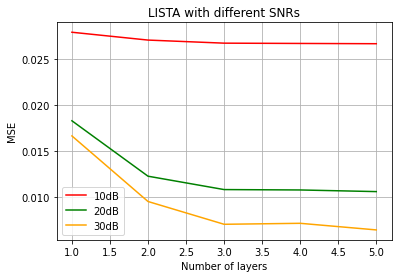

In [12]:
plt.figure()
plt.plot(range(1,num_layers+1), results_to_plot_10, label="10dB", color='red')
plt.plot(range(1,num_layers+1), results_to_plot_20, label="20dB", color='green')
plt.plot(range(1,num_layers+1), results_to_plot_30, label="30dB", color='orange')
plt.legend()
plt.grid(True, which='both')
plt.title("LISTA with different SNRs")
plt.xlabel("Number of layers")
plt.ylabel("MSE")
plt.show()

# Comparig noisy versions of IST, AMP, LISTA

10 dB

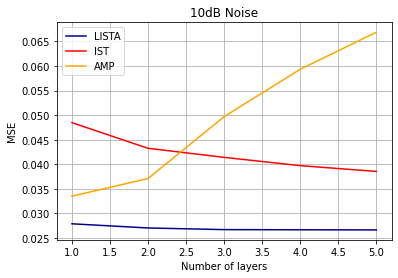

In [5]:
amp = [0.03351551957207044,0.03710174695397633,0.049700209437273796,0.059340006810899196,0.06688350727977954]
ist = [0.048483316782791504,0.0432581566013954,0.041413456523064184,0.03973113387893762,0.03854807959547184]
results_to_plot_10 = [0.02789120376110077, 0.0270402729511261, 0.026705309748649597, 0.02667381428182125, 0.026644792407751083]

plt.figure()
plt.plot(range(1,num_layers+1), results_to_plot_10, label="LISTA", color='darkblue')
plt.plot(range(1,num_layers+1), ist, label="IST", color='red')
plt.plot(range(1,num_layers+1), amp, label="AMP", color='orange')
plt.legend()
plt.grid(True, which='both')
plt.title("10dB Noise")
plt.xlabel("Number of layers")
plt.ylabel("MSE")
plt.show()

20 dB

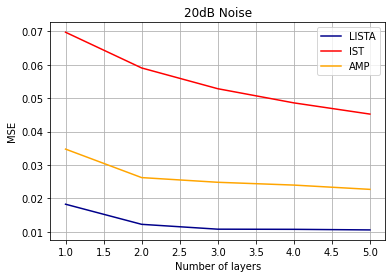

In [7]:
amp = [0.03476688923576817,0.026239176536562072,0.024835154122956553,0.023997278169850485,0.022715335739052375]
ist = [0.06974471499760325,0.059056054614071075,0.05284524149955967,0.04860481471683571,0.04524668391688237]
results_to_plot_20 = [0.01827082596719265, 0.012250917963683605, 0.01079740934073925, 0.01075495220720768, 0.010577300563454628]

plt.figure()
plt.plot(range(1,num_layers+1), results_to_plot_20, label="LISTA", color='darkblue')
plt.plot(range(1,num_layers+1), ist, label="IST", color='red')
plt.plot(range(1,num_layers+1), amp, label="AMP", color='orange')
plt.legend()
plt.grid(True, which='both')
plt.title("20dB Noise")
plt.xlabel("Number of layers")
plt.ylabel("MSE")
plt.show()

30 dB

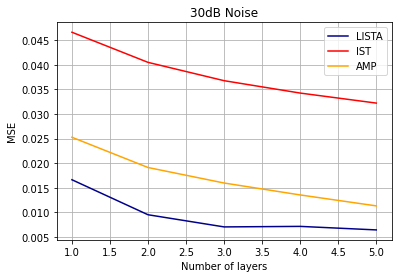

In [8]:
amp = [0.02527132079894632,0.019114618338226343,0.015958564411437413,0.01353177935473605,0.011305069539771756]
ist = [0.04664131621128827,0.040511579821066325,0.03678316626770388,0.03426355632693642,0.03222492721471602]
results_to_plot_30 = [0.016626276075839996, 0.009502106346189976, 0.007026088424026966, 0.007132936269044876, 0.00641442509368062]

plt.figure()
plt.plot(range(1,num_layers+1), results_to_plot_30, label="LISTA", color='darkblue')
plt.plot(range(1,num_layers+1), ist, label="IST", color='red')
plt.plot(range(1,num_layers+1), amp, label="AMP", color='orange')
plt.legend()
plt.grid(True, which='both')
plt.title("30dB Noise")
plt.xlabel("Number of layers")
plt.ylabel("MSE")
plt.show()

# Looking at 2 BS

In [9]:
# Define simulation parameters
n = 270
N = 1024
k = 40
sigma = 0.05
s = 0.2
lambda_ = 0.1
num_iterations = 5

In [10]:
# SD * random array of size nxN
A = np.sqrt(1/n)*np.random.randn(n, N)

# Track MSE vs iterations
#array of zeros the size of the iterations
mse_vs_iterations = np.zeros(num_iterations)
mse_vs_iterationsA = np.zeros(num_iterations)
mse_vs_iterationsB = np.zeros(num_iterations)

# Generate sparse vector x
x = np.zeros((N, 1))
idx_nonzero_entries = np.random.permutation(N)[0:k]
non_zero_entries = np.random.randint(10, size=(k, 1))+1
x[idx_nonzero_entries] = 1

# Generate noise vector w
# converts it to a column vector. nX1
w = sigma*np.random.randn(n).reshape(-1, 1)
w1 = sigma*np.random.randn(n).reshape(-1,1)

# Generate measurement vector y - note that a @ b is equal to np.matmul(a, b)
y = A @ x + w 
yb = A @ x + w1

# Prep for IST/AMP
z = np.zeros(y.shape)
xHt = np.zeros(x.shape)

In [13]:
# IST one base station
mse_vs_iter = np.zeros(num_iterations)
for i in range(num_iterations):
    z = y - A @ xHt
    r = xHt + s* A.T @ z
    xHt = eta(r, s*lambda_)
    err_sum = np.sum((x-xHt)**2)
    mse_vs_iter[i] = (1/N) * err_sum

In [14]:
# reset the estimate and error
z = np.zeros(y.shape)
xHt = np.zeros(x.shape)

# MSE vs iterations
mse_vs_iter1 = np.zeros(num_iterations)
for idx_iter in range(num_iterations):
    za = y - A @ xHt
    r = xHt + s * A.T @ za
    xHt = eta(r, s*lambda_)
# find the current error
    err_sum1 = np.sum((x - xHt)**2)
    
# do the same for second vector
    zb = yb - A @ xHt
    r = xHt + s * A.T @ zb
    xHt = eta(r, s*lambda_)
# find the current error
    err_sum2 = np.sum((x - xHt)**2)
    
    # average the error together
    mse_vs_iter1[idx_iter] = (1/(2*N)) * (err_sum1 +  err_sum2)

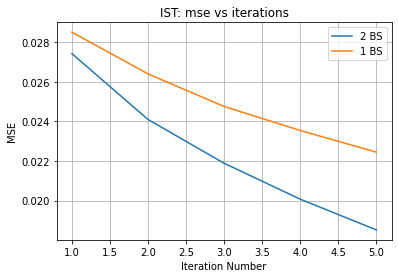

In [16]:
# Plot results
plt.figure()
plt.plot(range(1,num_iterations+1), mse_vs_iter1, label="2 BS")
plt.plot(range(1,num_iterations+1), mse_vs_iter, label="1 BS")
plt.legend()
plt.xlabel('Iteration Number')
plt.ylabel('MSE')
plt.grid(True, which='both')
plt.title("IST: mse vs iterations")
plt.show()

In [17]:
print(mse_vs_iter)
print(mse_vs_iter1)

[0.02850401 0.02639663 0.02475163 0.02353836 0.02244425]
[0.02742238 0.02409456 0.02188123 0.02006836 0.01851366]


In [19]:
one_bs_ist = [0.02850401, 0.02639663, 0.02475163, 0.02353836, 0.02244425]
two_bs_ist = [0.02742238, 0.02409456, 0.02188123, 0.02006836, 0.01851366]
lista = [.015, .0094, .006,.0047, .003]

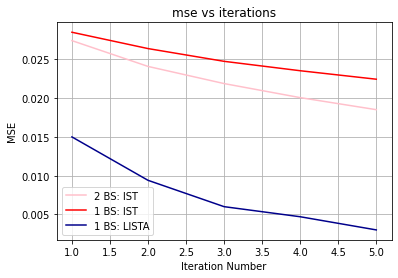

In [23]:
plt.figure()
plt.plot(range(1,num_iterations+1), two_bs_ist, label="2 BS: IST", color='pink')
plt.plot(range(1,num_iterations+1), one_bs_ist, label="1 BS: IST", color='red')
plt.plot(range(1,num_iterations+1), lista, label="1 BS: LISTA", color="darkblue")
plt.legend()
plt.xlabel('Iteration Number')
plt.ylabel('MSE')
plt.grid(True, which='both')
plt.title("mse vs iterations")
plt.show()